# Dose levels reached in scTF-seq compared to other overexpression datasets

In scTF-seq, we specifically chose a construct that can reach a variety of dose levels. A key challenge in many overexpression or CRISPRa studies is that dose levels are not high enough to reach physiological levels. To investigate this, we compare the dose levels reached in scTF-seq to those reached in other datasets, such as the MORF dataset (Joung et al. 2023).

Given that we are working in another context then Joung et al. (mESCs vs C3H10), this comparison is not straightforward. Moreover, the overlap between overexpressed genes at high-enough power levels between both datasets is sadly very small. In the end, only one TF led to a useful comparison: Fos, which has a strong response in both mESCs and C3H10 cells. We will focus on DE genes that are shared between both datasets, and compare their differential expression at various dose levels.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import tqdm.auto as tqdm

import jax
import latenta as la
import polyptich as pp

pp.setup_ipython()

import eyck
import seaborn as sns

In [2]:
import pathlib
plots_folder = pathlib.Path("plots")
if not plots_folder.exists():
    plots_folder.mkdir(parents=True)
data_folder = pp.paths.get_data()

## Download and load MORF

We use data from the MORF dataset (Joung et al. 2023) to compare exogenous TF expression.

In [3]:
import scanpy as sc

In [4]:
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216595/suppl/GSE216595%5F180124%5Fperturb%2Eh5ad%2Egz"
if not pathlib.Path("GSE216481/GSE216595_180124_perturb.h5ad").exists():
    pathlib.Path("GSE216481").mkdir(exist_ok=True, parents=True)
    !wget {url} -O GSE216481/GSE216595_180124_perturb.h5ad.gz
    !gunzip GSE216481/GSE216595_180124_perturb.h5ad.gz

In [5]:
adata_morf = sc.read_h5ad("GSE216481/GSE216595_180124_perturb.h5ad")

In [6]:
adata2_morf = adata_morf[
    adata_morf.obs["TF"].str.contains("FOS-")
    | adata_morf.obs["TF"].str.contains("STAT3")
]
adata2_morf.obs["TF"].value_counts()

TF
FOS-NM_005252      990
STAT3-NM_213662    301
STAT3-NM_003150    264
Name: count, dtype: int64

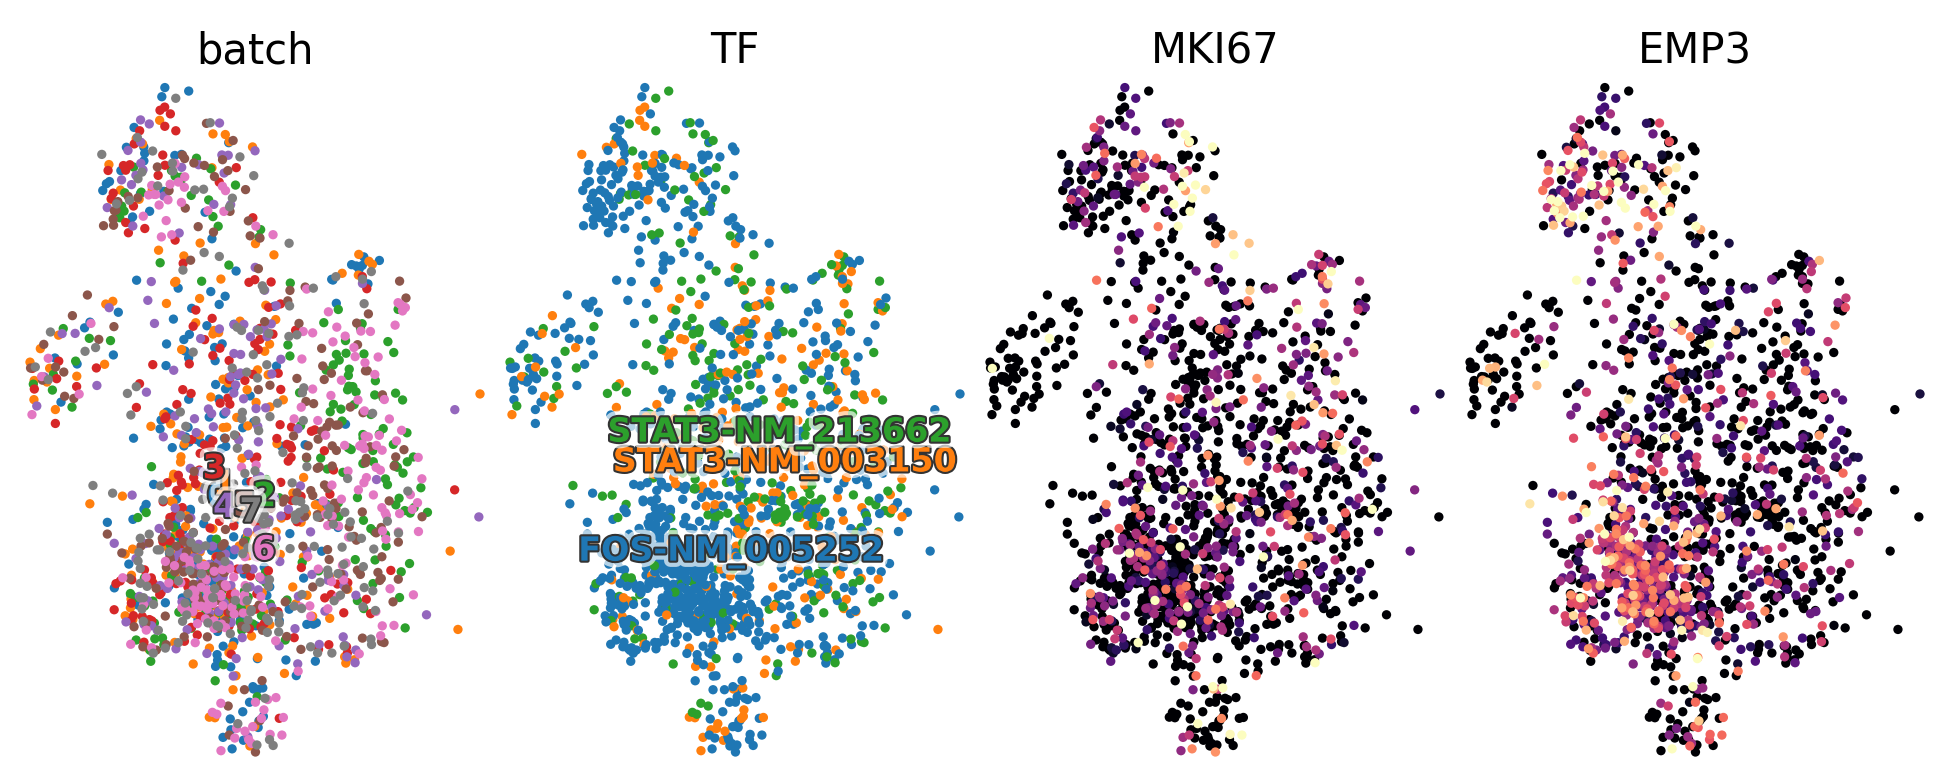

In [7]:
eyck.m.t.plot_umap(adata2_morf, color=["batch", "TF", "MKI67", "EMP3"]).display()

In [8]:
diffexp_morf = eyck.m.t.diffexp.compare_two_groups(
    adata2_morf, adata2_morf.obs["TF"].str.contains("FOS").values
)
# diffexp.loc["CAV1"]
diffexp_morf.loc["S100A6"]

/srv/data/wouters/tools/eyck/src/eyck/modalities/transcriptome/diffexp.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["oi"] = pd.Categorical(


scores            1.327815e+01
logfoldchanges    1.761460e+00
pvals             3.570290e-38
pvals_adj         8.929653e-35
lfc               9.321628e-01
pct.1             2.323232e-02
pct.2             3.893805e-02
scoreLM           6.330030e-01
Name: S100A6, dtype: float64

Because not all cells that have high Fos barcode expression are acatually perturbed, we will only use the cells that cluster in a separate Fos-enriched cluster.

In [9]:
sc.pp.pca(adata2_morf)
sc.pp.neighbors(adata2_morf)
sc.tl.umap(adata2_morf)
sc.tl.leiden(adata2_morf, resolution=0.5)
adata2_morf = adata2_morf[adata2_morf.obs["leiden"].isin(["0", "1"])]

2025-08-08 16:06:17.535054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754661977.544293 3946609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754661977.546779 3946609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754661977.554142 3946609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754661977.554147 3946609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754661977.554149 3946609 computation_placer.cc:177] computation placer alr

/tmp/ipykernel_3946609/1067945886.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata2_morf, resolution=0.5)


In [10]:
sc.pp.pca(adata2_morf)
sc.pp.neighbors(adata2_morf)
sc.tl.umap(adata2_morf)

/srv/data/allUsers/wouters/miniconda3/envs/crispyKC/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


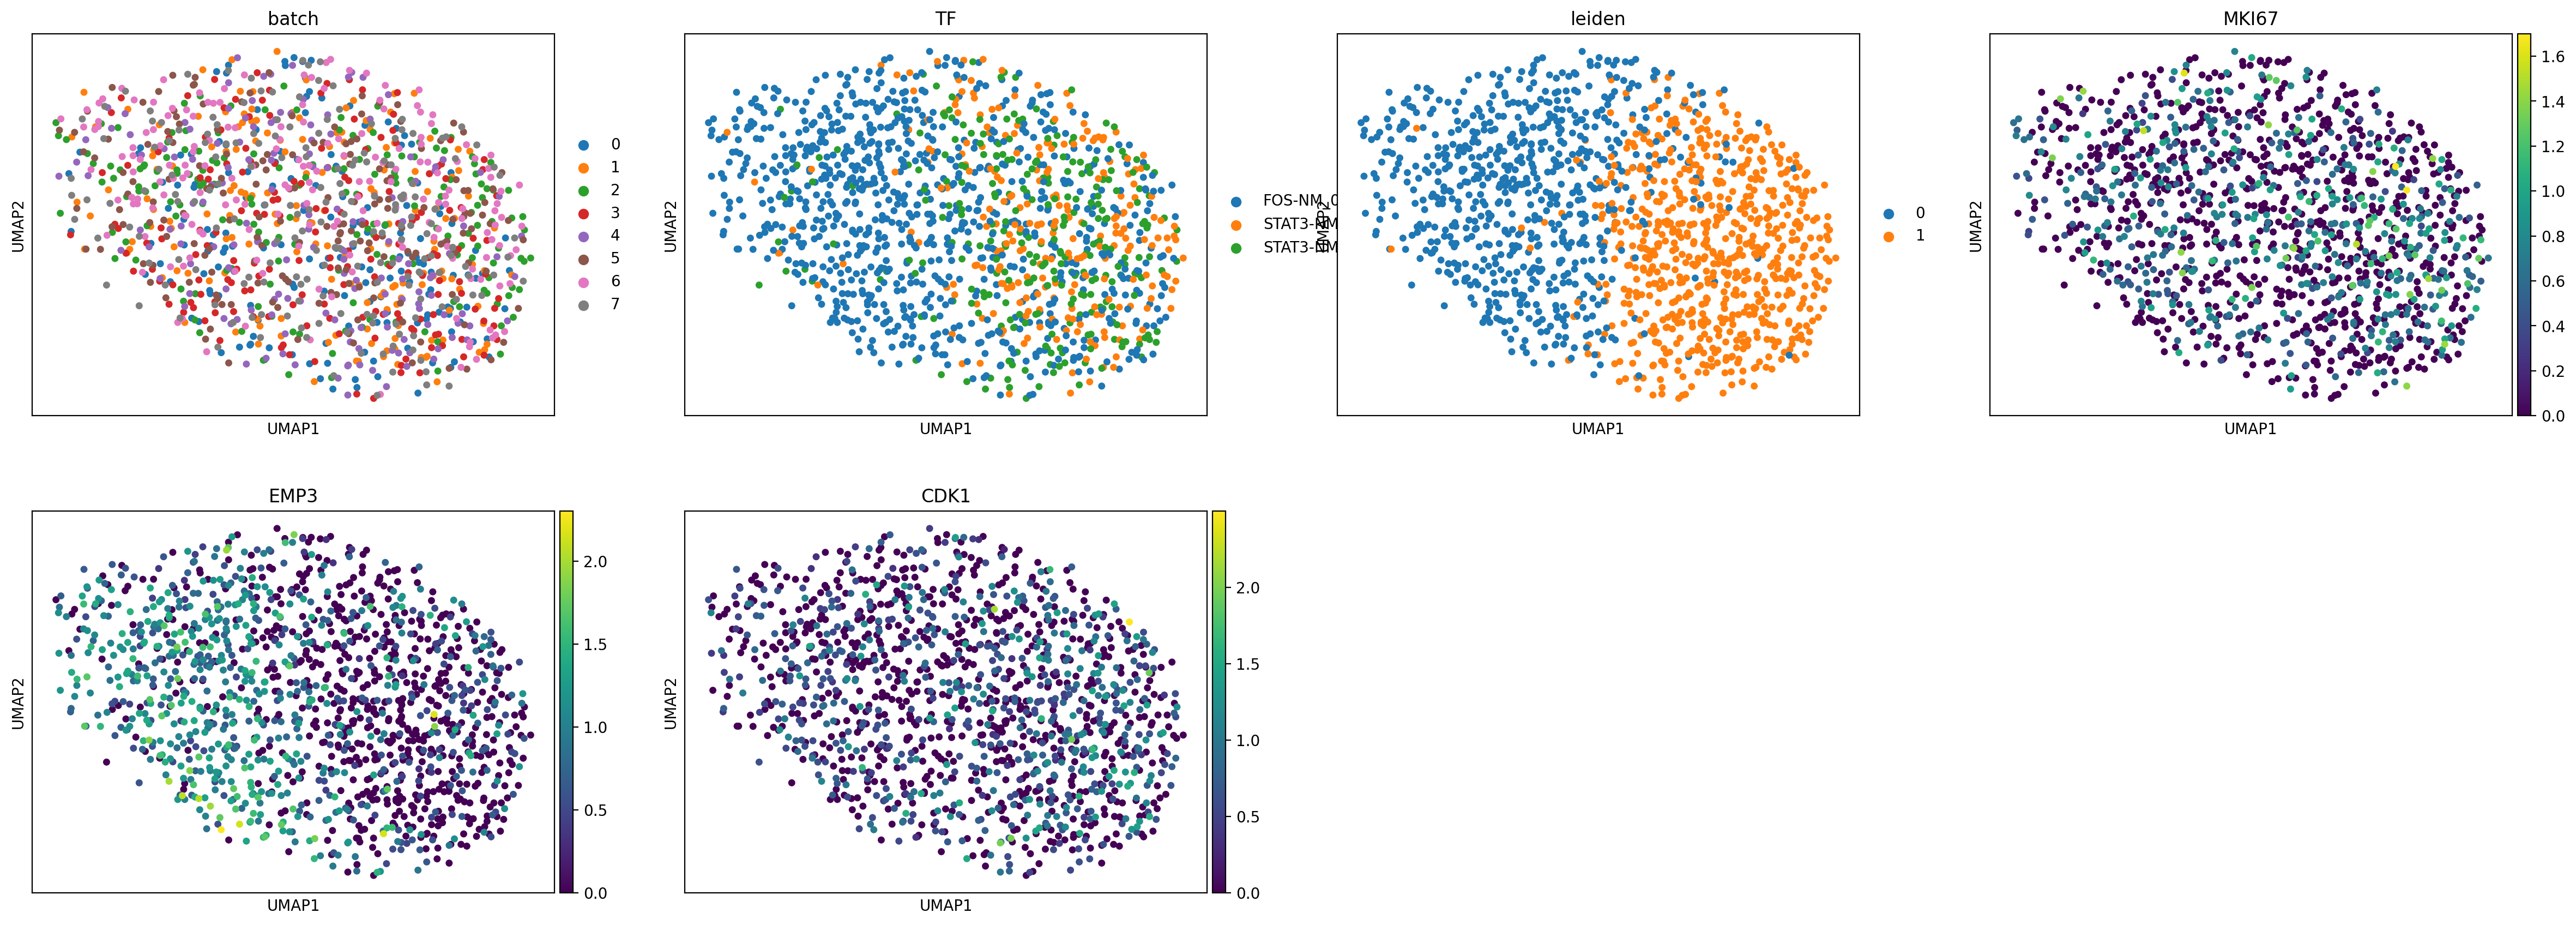

In [11]:
sc.pl.umap(adata2_morf, color=["batch", "TF", "leiden", "MKI67", "EMP3", "CDK1"])

In [12]:
adata2_morf.obs["TF2"] = ["FOS" if x == "0" else "mCherry" for x in adata2_morf.obs["leiden"]]

In [13]:
diffexp_morf2 = eyck.m.t.diffexp.compare_two_groups(
    adata2_morf,
    adata2_morf.obs["TF2"].isin(["FOS"]),
    adata2_morf.obs["TF2"].isin(["mCherry"]),
)
diffexp_morf2["lfc"] = (
    np.array(
        np.array(adata2_morf.raw.to_adata().X[adata2_morf.obs["leiden"].isin(["0"]).values].mean(0))[0]
    )
    - np.array(
        np.array(adata2_morf.raw.to_adata().X[adata2_morf.obs["leiden"].isin(["1"]).values].mean(0))[0]
    )
)
diffexp_morf2 = diffexp_morf2.groupby("gene").first()

## Load scTF-seq data

In [14]:
obs = pd.read_csv(data_folder / "obs.csv").rename(columns={"Unnamed: 0": "cell"}).set_index("cell")
mtx = scipy.io.mmread(data_folder / "matrix.mtx").T.tocsr()
obs["ix"] = range(obs.shape[0])

var = pd.read_csv(data_folder / "var.csv", index_col=0)

In [15]:
def extract_tf_dataset(mtx, obs, tf, batches=None):
    if isinstance(tf, str):
        tf = [tf]
    obs_oi = obs[obs["TF"].isin(tf)]
    if batches is not None:
        obs_oi = obs_oi[obs_oi["batch_overall"].isin(batches)]
    batches = obs_oi["batch_overall"].unique()
    obs_ref = obs[
        (obs["batch_overall"].isin(batches)) & (obs["TF"].isin(["D0_confluent"]))
    ]

    obs = pd.concat([obs_ref, obs_oi])
    obs = obs.loc[obs["Phase_corrected"] == "G1"]
    counts = mtx.tocsr()[obs["ix"].values, :]

    return counts, obs

In [16]:
import scanpy as sc

counts_oi, obs_oi = extract_tf_dataset(mtx, obs, ["Fos"], batches=["batch6"])

genes_oi = np.array(counts_oi.sum(0))[0] > 5
counts_oi = counts_oi[:, genes_oi]
var_oi = var.iloc[genes_oi]
len(var_oi), len(obs_oi)

(14291, 609)

In [17]:
adata = sc.AnnData(X=counts_oi, obs=obs_oi, var=var_oi)

In [18]:
counts = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [19]:
oi = adata.obs["TF"] == "Fos"
noi = ~oi
diffexp = eyck.m.t.diffexp.compare_two_groups(adata, oi)
diffexp["lfc"] = np.array(adata.X[oi.values].mean(0))[0] - np.array(adata.X[noi.values].mean(0))[0]
diffexp = diffexp.groupby("symbol").first()

## Compare fold-changes

(-5.0, 5.0)

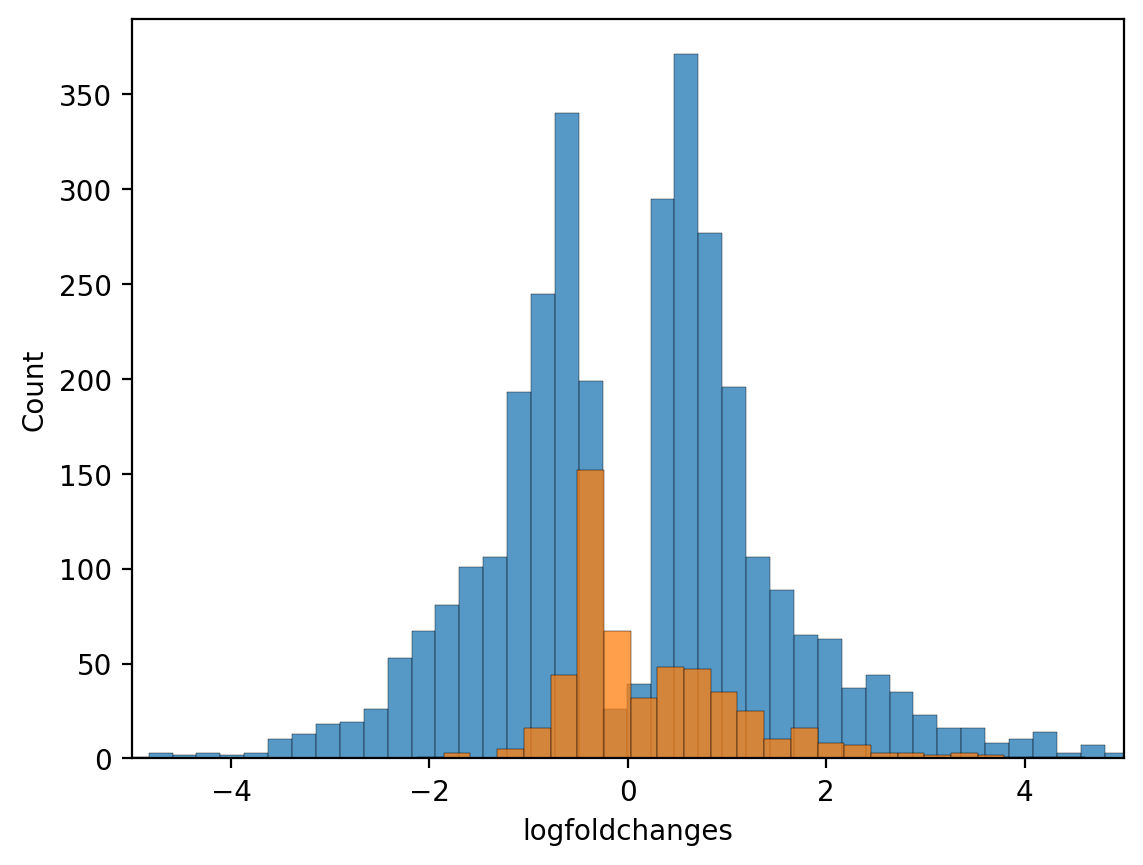

In [20]:
fig, ax = plt.subplots()
sns.histplot(diffexp.query("pvals_adj < 0.05")["logfoldchanges"])
sns.histplot(diffexp_morf.query("pvals_adj < 0.05")["logfoldchanges"])
ax.set_xlim(-5, 5)

(-5.0, 5.0)

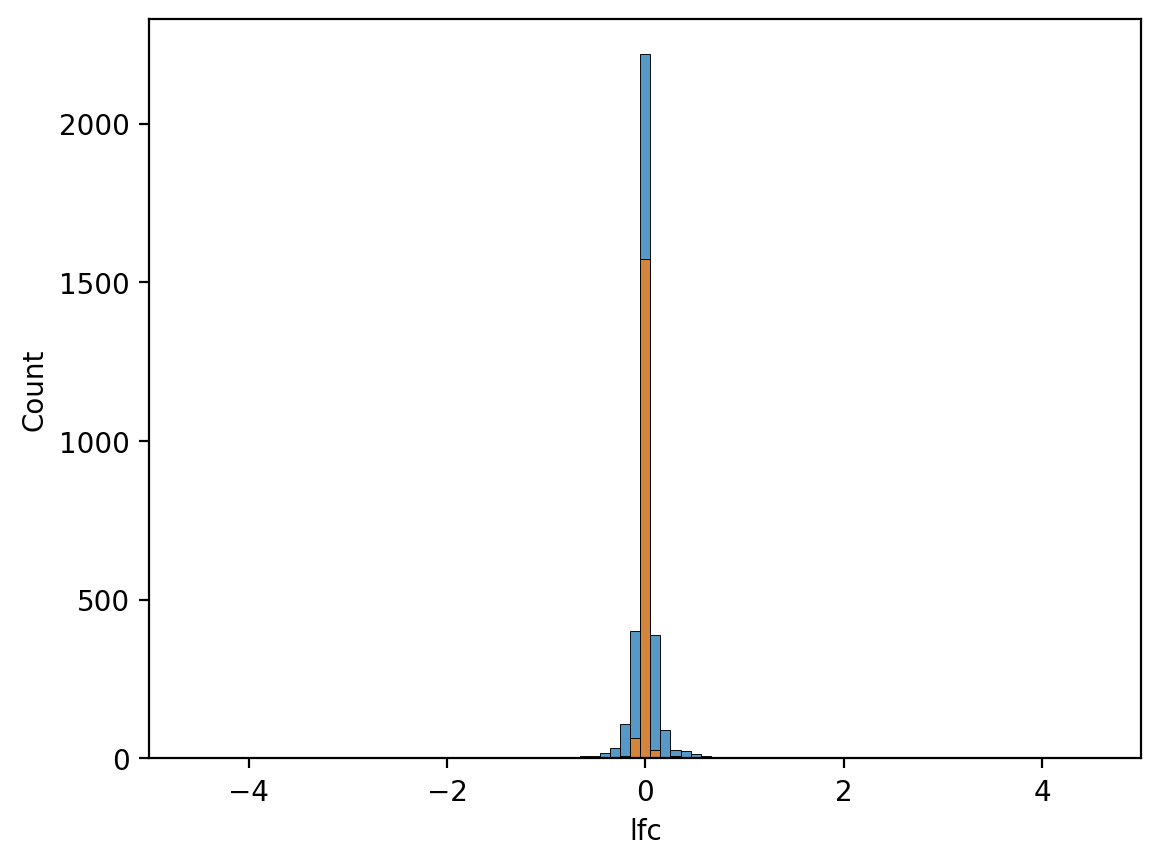

In [21]:
fig, ax = plt.subplots()
sns.histplot(diffexp.query("pvals_adj < 0.05")["lfc"], bins=np.linspace(-5, 5, 100))
sns.histplot(
    diffexp_morf2.query("pvals_adj < 0.05")["lfc"], bins=np.linspace(-5, 5, 100)
)
ax.set_xlim(-5, 5)

## Extract shared DE genes

Given that we work in different contexts, we cannot simply compare one set of DE genes with another. Instead, we will focus on the intersection of DE genes.

In [22]:
gene_mapping = pd.DataFrame({"gene_mouse": diffexp.index})
gene_mapping["gene_human"] = gene_mapping["gene_mouse"].str.upper()
gene_mapping["shared"] = gene_mapping["gene_human"].isin(diffexp_morf2.index)
gene_mapping = gene_mapping.loc[gene_mapping["shared"]]

diffexp_shared = pd.concat(
    [
        diffexp
        .loc[gene_mapping["gene_mouse"]]
        .rename(
            columns={
                "logfoldchanges": "logfoldchanges_mouse",
                "pvals_adj": "pvals_adj_mouse",
                "scores": "scores_mouse",
            }
        )[["logfoldchanges_mouse", "pvals_adj_mouse", "scores_mouse"]]
        .reset_index(),
        diffexp_morf2.loc[gene_mapping["gene_human"]]
        .rename(
            columns={
                "logfoldchanges": "logfoldchanges_human",
                "pvals_adj": "pvals_adj_human",
                "scores": "scores_human",
            }
        )[["logfoldchanges_human", "pvals_adj_human", "scores_human"]]
        .reset_index(),
    ],
    axis=1,
    ignore_index=True,
)
diffexp_shared.columns = [
    "gene_mouse",
    "logfoldchanges_mouse",
    "pvals_adj_mouse",
    "scores_mouse",
    "gene_human",
    "logfoldchanges_human",
    "pvals_adj_human",
    "scores_human",
]
diffexp_shared_diff = diffexp_shared.query(
    "abs(scores_mouse) > 5 & abs(scores_human) > 5"
).dropna()
diffexp_shared_diff.shape

(90, 8)

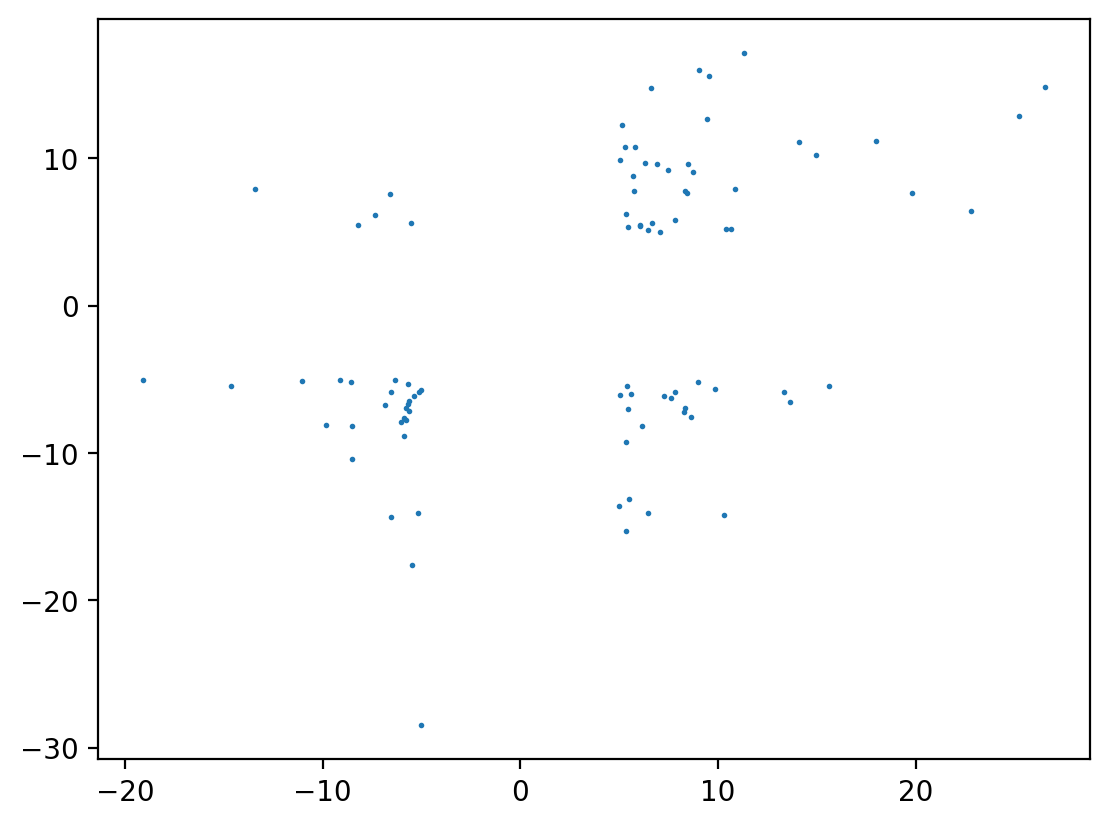

In [23]:
fig, ax = plt.subplots()
ax.scatter(
    diffexp_shared_diff["scores_mouse"],
    diffexp_shared_diff["scores_human"],
    s=1,
)

Shared DE gene fold-changes are moderately correlated.

In [24]:
np.corrcoef(
    diffexp_shared_diff["scores_mouse"],
    diffexp_shared_diff["scores_human"],
)

array([[1.        , 0.45818273],
       [0.45818273, 1.        ]])

In [25]:
adata.obs["nCount_RNA"].mean(), adata2_morf.obs["n_counts"].mean()

(np.float64(18269.69786535304), np.float32(11938.384))

In [26]:
diffexp_shared.query("abs(logfoldchanges_mouse) > log(2) & pvals_adj_mouse < 0.05").shape, diffexp_shared.query("abs(logfoldchanges_human) > log(2) & pvals_adj_human < 0.05").shape

((1733, 8), (259, 8))

In [27]:
diffexp_shared_diff.sort_values("pvals_adj_human", ascending = True).query("logfoldchanges_human > 1").query("logfoldchanges_mouse > 1")

gene_mouse  logfoldchanges_mouse  pvals_adj_mouse  scores_mouse  \
1180       Cav1              3.490770     1.748995e-99     26.541584   
7777     S100a6              1.739482     1.917336e-78     25.240650   
7775     S100a4              1.078565     8.033047e-50     17.990761   
445       Anxa1              1.255735     3.058271e-33     14.091554   
9054      Tgfb1              1.805635     1.460995e-15      8.726941   
1792     Col6a1              1.606840     1.400182e-56     19.810778   
1395      Cdh13              1.370028     1.453160e-14      8.451538   
1181       Cav2              2.900094     6.239628e-78     22.783649   
1795     Col7a1              4.316538     1.252555e-12      7.836739   
269      Ahnak2              1.531924     1.602081e-09      6.672202   
4327      Kcnn4              3.913247     4.625726e-22     10.645463   
3277      Fxyd3              2.575244     4.826074e-09      6.479055   

     gene_human  logfoldchanges_human  pvals_adj_human  scores_human  
1180       CAV1              2.187641     3.318404e-42     14.812400  
7777     S100A6              1.802289     1.597741e-32     12.834143  
7775     S100A4              1.186990     5.474215e-25     11.148396  
445       ANXA1              2.607457     1.462568e-24     11.131300  
9054      TGFB1              1.101220     8.216615e-17      9.081751  
1792     COL6A1              1.390559     5.186148e-12      7.653912  
1395      CDH13              2.896582     7.013349e-12      7.643512  
1181       CAV2              1.993731     1.749500e-08      6.424320  
1795     COL7A1              3.239167     6.040168e-07      5.811240  
269      AHNAK2              2.477698     1.896207e-06      5.582208  
4327      KCNN4              3.543320     1.311556e-05      5.191486  
3277      FXYD3              5.236089     1.625057e-05      5.150339

/srv/data/allUsers/wouters/miniconda3/envs/crispyKC/lib/python3.12/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/srv/data/allUsers/wouters/miniconda3/envs/crispyKC/lib/python3.12/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/srv/data/allUsers/wouters/miniconda3/envs/crispyKC/lib/python3.12/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/srv/data/allUsers/wouters/miniconda3/envs/crispyKC/lib/python3.12/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on

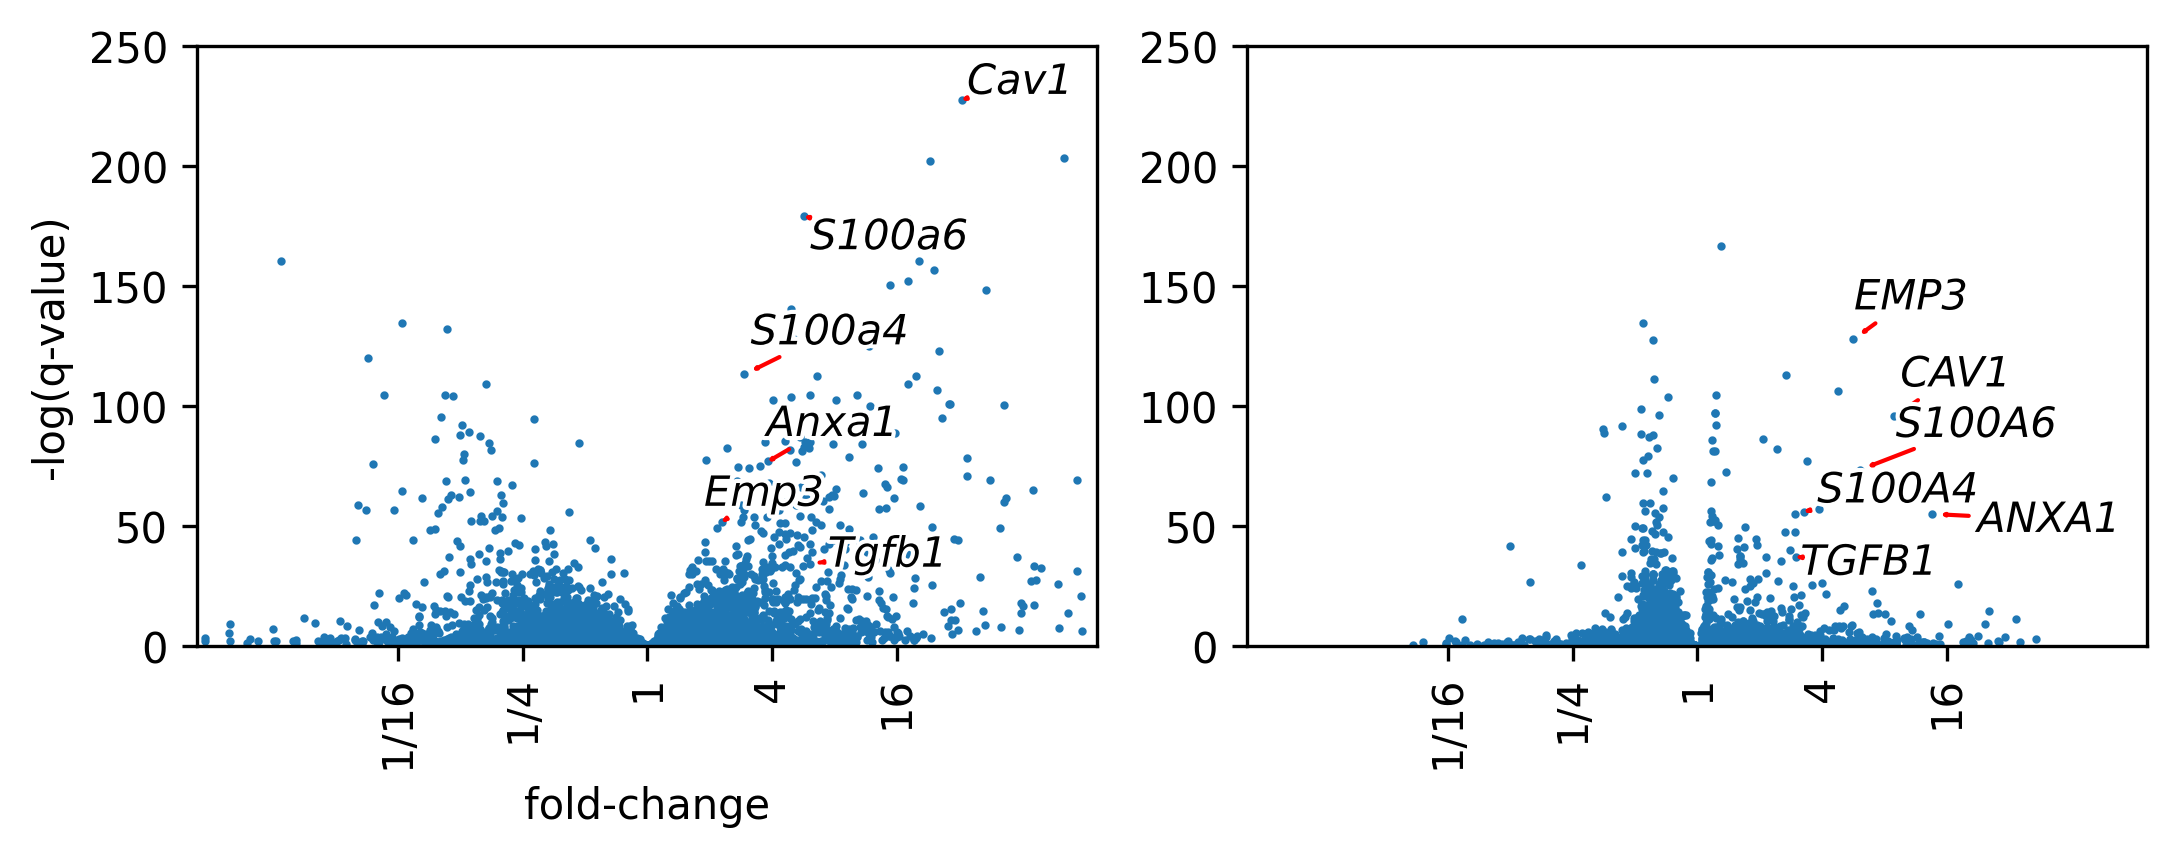

In [28]:
# label = ["Cav1", "S100a6", "Rspo2"]
label = ["Emp3", "Cav1", "S100a6", "S100a4", "Anxa1", "Tgfb1"]

fig = pp.Figure()
ax = fig.main.add_right(pp.Panel((3, 2)))
plotdata = diffexp_shared.copy()
plotdata["x"] = plotdata["logfoldchanges_mouse"]
plotdata["y"] = -np.log(plotdata["pvals_adj_mouse"])
ax.scatter(
    plotdata["x"], plotdata["y"],
    s=1,
)
texts = []
for gene in label:
    ix = diffexp_shared["gene_mouse"] == gene
    texts.append(ax.text(
        plotdata["x"][ix],
        plotdata["y"][ix],
        gene,
        fontstyle = "italic",
        # bbox=dict(facecolor='white', pad=0.4),
    ))
    texts[-1].set_path_effects([mpl.patheffects.withStroke(linewidth=2, foreground='white')])
ax.set_xlim(-5, 5)
ax.set_xticks(np.log([1/16, 1/4, 1, 4, 16]))
ax.set_xticklabels(["1/16", "1/4", 1, 4, 16], fontsize = 10, rotation = 90)
ax.set_ylabel("-log(q-value)")
ax.set_ylim(0, 250)
# ax.axhline(-np.log(0.05), color='grey', linestyle='--')
ax.set_xlabel("fold-change")

fig.plot()
import adjustText
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red'), ax = ax, min_arrow_len =0)


ax = fig.main.add_right(pp.Panel((3, 2)))
plotdata = diffexp_shared.copy()
plotdata["x"] = plotdata["logfoldchanges_human"]
plotdata["y"] = -np.log(plotdata["pvals_adj_human"])
s = ax.scatter(
    plotdata["x"], plotdata["y"],
    s=1,
)
texts = []
for gene in label:
    ix = diffexp_shared["gene_human"] == gene.upper()
    texts.append(ax.text(
        plotdata["x"][ix],
        plotdata["y"][ix],
        gene.upper(),
        fontstyle = "italic",
        # bbox=dict(facecolor='white', pad=0.4),
    ))
    texts[-1].set_path_effects([mpl.patheffects.withStroke(linewidth=2, foreground='white')])
ax.set_xticks(np.log([1/16, 1/4, 1, 4, 16]))
ax.set_xticklabels(["1/16", "1/4", 1, 4, 16], fontsize = 10, rotation = 90)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 250)
# ax.axhline(-np.log(0.05), color='grey', linestyle='--')

fig.plot()
import adjustText
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red'), ax = ax, min_arrow_len =0)

# ax = fig.main.add_right(pp.Panel((2, 2)))
# plotdata = diffexp_shared_diff.copy()
# plotdata["x"] = plotdata["scores_human"]
# plotdata["y"] = plotdata["scores_mouse"]
# s = ax.scatter(
#     plotdata["x"], plotdata["y"],
#     s=1,
# )
# texts = []
# for gene in label:
#     ix = diffexp_shared["gene_human"] == gene.upper()
#     texts.append(ax.text(
#         plotdata["x"][ix],
#         plotdata["y"][ix],
#         gene,
#         # bbox=dict(facecolor='white', pad=0.4),
#     ))
#     texts[-1].set_path_effects([mpl.patheffects.withStroke(linewidth=2, foreground='white')])
# ax.set_xticks(np.log([1/16, 1/4, 1, 4, 16]))
# ax.set_xticklabels(["1/16", "1/4", 1, 4, 16], fontsize = 10, rotation = 90)
# ax.axhline(-np.log(0.05), color='grey', linestyle='--')

# fig.plot()
# import adjustText
# adjustText.adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red'), ax = ax, min_arrow_len =0)
fig.display()

fig.savefig(plots_folder / "dose_diffexp_comparison.pdf")

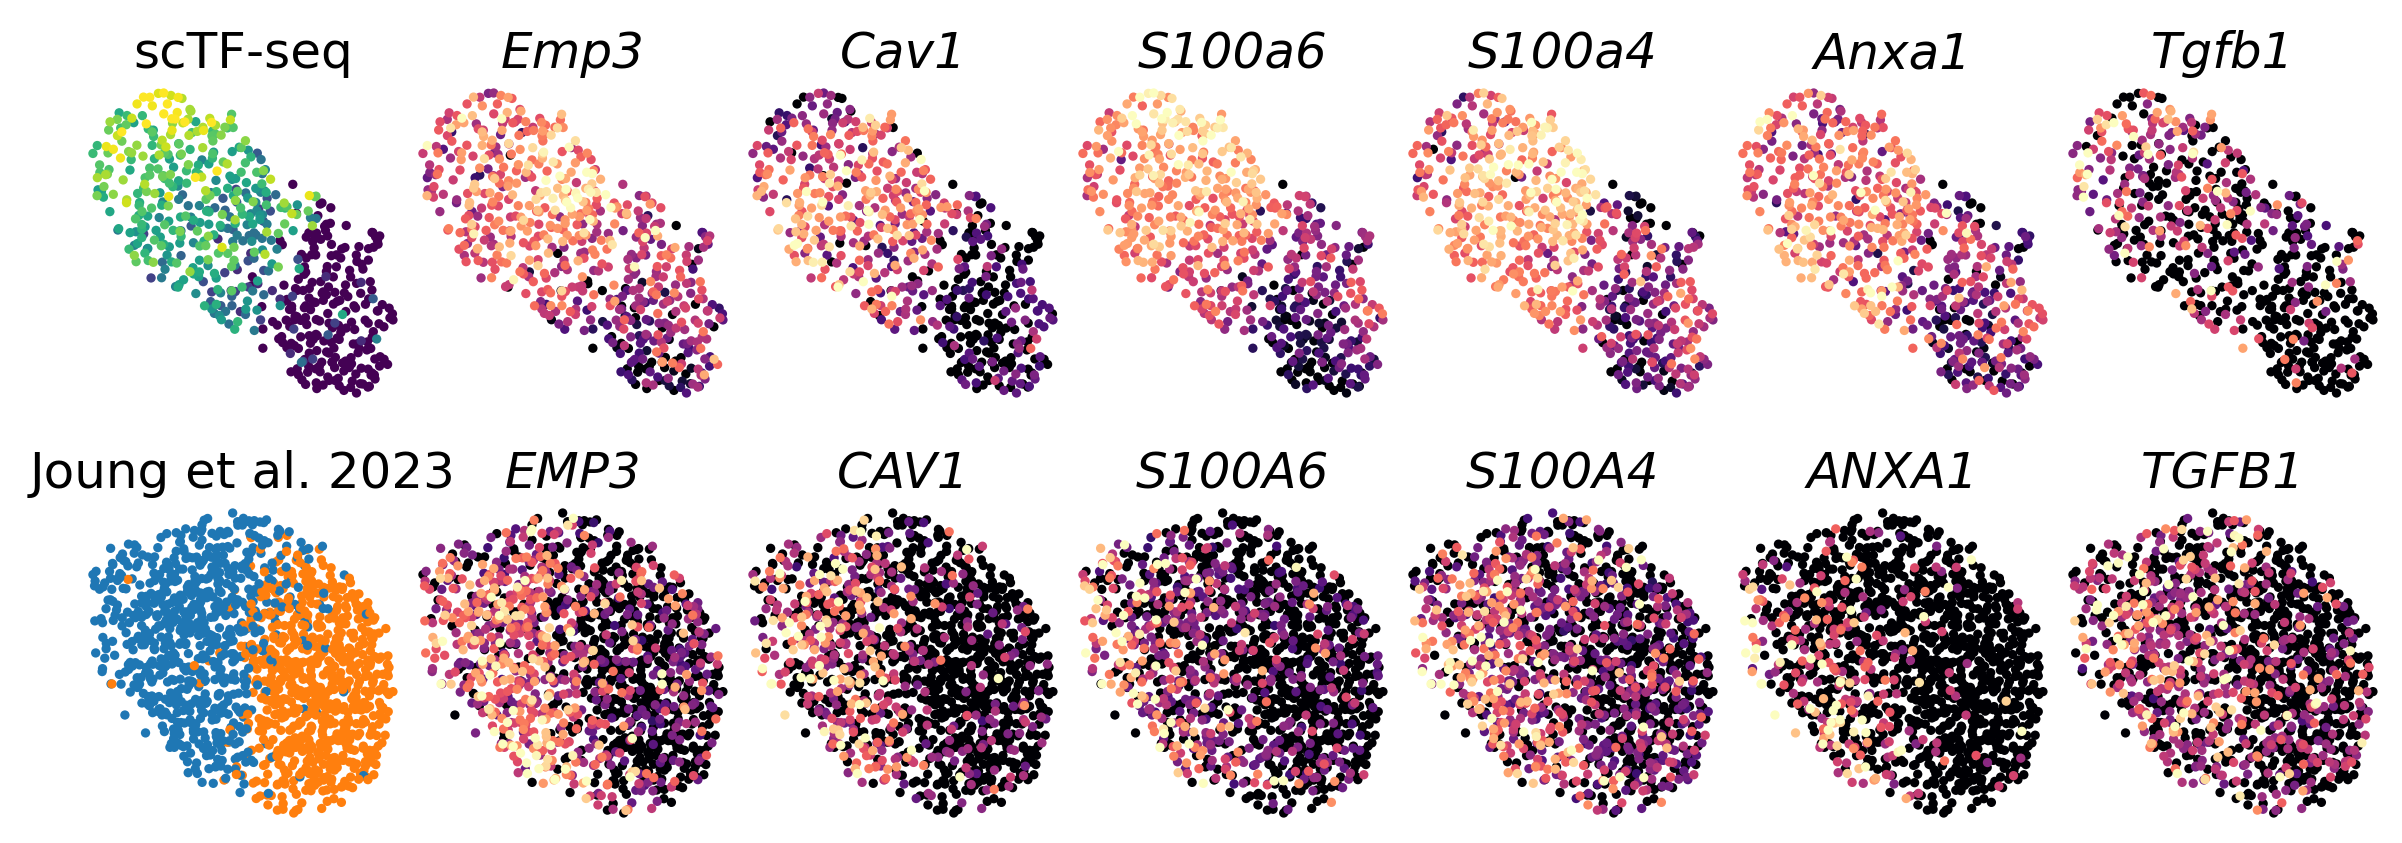

In [29]:
fig = pp.Figure(pp.grid.Grid(padding_width = 0.1, padding_height = 0.4))

ax = fig.main.add_right(pp.Panel((1, 1)), row = 0)
adata.obs["TF2"] = ["FOS" if x == "Fos" else "mCherry" for x in adata.obs["TF"]]
eyck.m.t.plot_umap(adata, color="Dose", ax=ax, legend = False, cmap = "viridis", show_norm = False)
ax.set_title("scTF-seq")

ax = fig.main.add_right(pp.Panel((1, 1)), row = 1)
eyck.m.t.plot_umap(adata2_morf, color="TF2", ax=ax, legend = False)
ax.set_title("Joung et al. 2023")

for symbol in ["Emp3", "Cav1", "S100a6", "S100a4", "Anxa1", "Tgfb1"]:
# for symbol in ["Cav1", "Serpine1", "Marcks", "Kcnn4"]:
    ax = fig.main.add_right(pp.Panel((1, 1)), row = 0)
    eyck.m.t.plot_umap(adata, color=symbol, ax=ax, norms = ("q.05", "q.98"), show_norm = False)
    ax.set_title(f"{symbol}", fontstyle = "italic")
    ax = fig.main.add_right(pp.Panel((1, 1)), row = 1)
    eyck.m.t.plot_umap(adata2_morf.raw.to_adata(), color=symbol.upper(), ax=ax, norms = ("q.05", "q.98"), show_norm = False)
    ax.set_title(f"{symbol.upper()}", fontstyle = "italic")
fig.display()


fig.savefig(plots_folder / "dose_diffexp_examples.pdf")

In [30]:
(
    np.exp(diffexp_shared_diff["logfoldchanges_mouse"].abs().mean()),
    np.exp(diffexp_shared_diff["logfoldchanges_human"].abs().mean()),
)

(np.float32(2.742537), np.float32(2.1950657))

In [31]:
diffexp_shared_diff.sort_values("scores_human")

gene_mouse  logfoldchanges_mouse  pvals_adj_mouse  scores_mouse  \
8007      Sfrp1             -1.315872     1.228012e-05     -5.015422   
4556       Ldhb             -1.278595     1.510813e-06     -5.464599   
3339      Gapdh              0.430586     2.343036e-06      5.367544   
6961      Psma4             -0.654659     5.848934e-09     -6.523051   
5082      Mfge8              1.524807     5.246222e-21     10.317881   
...         ...                   ...              ...           ...   
7666       Rps2              0.358461     2.847991e-09      6.630730   
1180       Cav1              3.490770     1.748995e-99     26.541584   
4575     Lgals1              0.637781     9.660449e-18      9.553288   
7770    S100a10              0.562456     3.802713e-16      9.024160   
2710       Emp3              0.829785     3.898533e-23     11.289702   

     gene_human  logfoldchanges_human  pvals_adj_human  scores_human  
8007      SFRP1             -2.389278    2.758517e-135    -28.457169  
4556       LDHB             -0.605824     3.705444e-59    -17.612982  
3339      GAPDH             -0.325133     1.145417e-45    -15.309468  
6961      PSMA4             -0.838883     1.466417e-40    -14.348627  
5082      MFGE8             -1.051513     5.822670e-40    -14.236427  
...         ...                   ...              ...           ...  
7666       RPS2              0.193241     9.266454e-43     14.773083  
1180       CAV1              2.187641     3.318404e-42     14.812400  
4575     LGALS1              1.562922     7.233328e-47     15.589577  
7770    S100A10              0.988102     1.165688e-49     16.013687  
2710       EMP3              1.734639     3.810708e-56     17.145578  

[90 rows x 8 columns]

## Kinetic over various dose levels

In [32]:
distributions = []
ns = []
genes_oi = diffexp_shared_diff["gene_mouse"]
# genes_oi = diffexp.query("pvals_adj < 0.05 & abs(logfoldchanges) > log(2)").index
for dose_cutoff in tqdm.tqdm(np.arange(2.5, 8, 0.25)):
    oi = (adata.obs["TF"] == "Fos") & (np.log1p(adata.obs["Vector_UMI"]) < dose_cutoff)
    noi = adata.obs["TF"] != "Fos"
    diffexp_oi = eyck.m.t.diffexp.compare_two_groups(adata, oi)
    distributions.append(
        diffexp_oi.set_index("symbol").loc[genes_oi, "logfoldchanges"].values
    )
    ns.append(diffexp_oi.query("pvals_adj < 0.05 & abs(logfoldchanges) > log(2)").shape[0])

  0%|          | 0/22 [00:00<?, ?it/s]

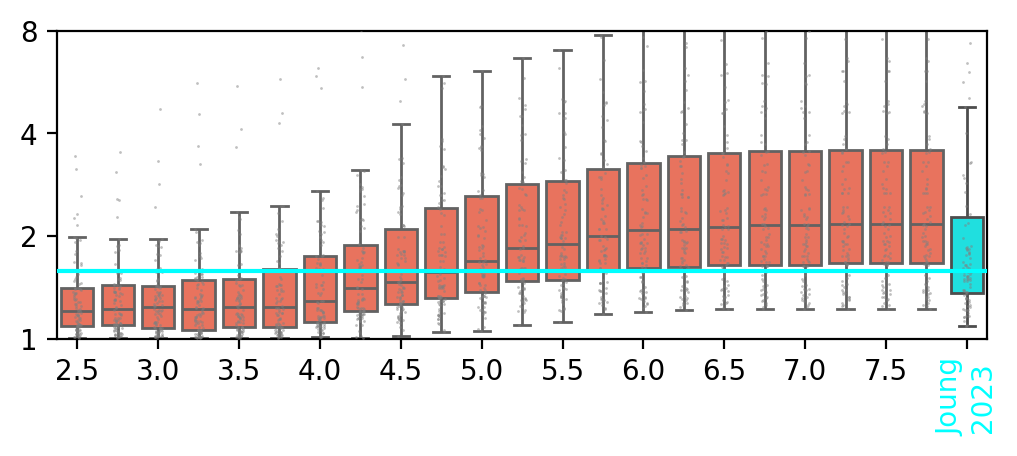

In [33]:
fig, ax = plt.subplots(figsize = (6, 2))

means = []
for x, dist in enumerate(distributions):
    dist_oi = np.abs(np.clip(dist, -3, 7))
    # vln = ax.violinplot(dist_oi, positions=[x], showextrema=False, showmedians = True)
    # for pc in vln['bodies']:
    #     pc.set_facecolor('#333')
    sns.boxplot(x=x, y=dist_oi, ax=ax, color = "tomato", showfliers = False, )
    sns.stripplot(x=x, y=dist_oi, ax=ax, s=1, color = "grey", zorder = 10, alpha = 0.5)
    means.append(np.median(dist_oi))
# ax.plot(means, color = "red")
ax.set_ylim(0, 2)

ax.set_yticks(np.log([1, 2, 4, 8]))
ax.set_yticklabels(["1", "2", "4", "8"], fontsize = 10)

x = x+1
dist = diffexp_shared_diff["logfoldchanges_human"].values
dist_oi = np.abs(np.clip(dist, -3, 7))
# ax.violinplot(dist_oi, positions=[x], showextrema=False, showmedians = True)
sns.boxplot(x=x+3, y=dist_oi, ax=ax, color = "cyan", showfliers = False)
sns.stripplot(x=x+3, y=dist_oi, ax=ax, s=1, zorder = 10, color = "grey", alpha = 0.5)
ax.axhline(np.median(dist_oi), zorder = 10, color = "cyan")
# ax.set_xlabel("scTF-seq", color = "tomato")

ticks = pd.DataFrame({"x": np.arange(0, len(means) + 1)})
ticks["label"] = (np.arange(2.5, 8, 0.25)).tolist() + ["Joung\n2023"]
ticks = ticks.iloc[::2]
ax.set_xticks(ticks["x"])
ax.set_xticklabels(ticks["label"], fontsize = 10)
ax.get_xticklabels()[-1].set_color("cyan")
ax.get_xticklabels()[-1].set_rotation(90)

fig.savefig(plots_folder / "dose_diffexp_kinetics.pdf", bbox_inches = "tight")